In [21]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import PIL
import os
from sys import platform
from importlib import reload
import plotly.graph_objects as go

# Local imports
import sys
sys.path.append('../../../')
import stlstuff as sls
import imagestuff as ims
import statstuff as sts
import fourierstuff as fs

In [22]:
%matplotlib notebook

In [23]:
# Have to do this in case of different operating systems
if platform == "linux" or platform == "darwin":
    slash = '/'
else: # This is assumed to be Windows
    slash = '\\'
#print(slash)

In [24]:
# Graphics parameters
fontsize = 10
linewidth = 2
matplotlib.rcParams.update({'font.size': fontsize})

In [25]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd(); startpos = len(pwd)-pwd[::-1].find(slash)
print(pwd)
case = pwd[startpos:]; print(case)
cwd = os.getcwd(); i = cwd.index('crystals'); case_and_folder = cwd[i+9:]; print(case_and_folder)
Segmentroot='Segments_Pyramidal'; print(Segmentroot)

/Users/Noah/Documents/GitHub/ice2021/crystals/2023-06-27/case2.1
case2.1
2023-06-27/case2.1
Segments_Pyramidal


In [26]:
# Get the retrieved surface
npzfile = np.load(Compressedfilename)
imageroot = np.array_str(npzfile['imageroot'])
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot, 'C')
print("dx and dy", dx, dy)

SEMimages/case2.1-A.bmp
SEMimages/case2.1-B.bmp
SEMimages/case2.1-C.bmp
SEMimages/case2.1-D.bmp
dx and dy 1.526442 1.526442


In [27]:
nx1list = npzfile['nx1list']
nx2list = npzfile['nx2list']
ny1list = npzfile['ny1list']
ny2list = npzfile['ny2list']
solution = npzfile['solution']
nsegments = len(nx1list)

In [28]:
# Graph the segments
im = PIL.Image.open(Filename)
ny_im,nx_im = np.shape(im)
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),2)
plt.imshow(np.asarray(im),cmap = 'Greys_r', vmin = 0,vmax = 255)
plt.title(case_and_folder)

Text(0.5, 1.0, '2023-06-27/case2.1')

In [29]:
# Flatten them
xseggrid, yseggrid, zseggrid, surf_xseggrid, surf_yseggrid, surf_zseggrid = ims.extractflat(npzfile,dx,dy)

In [30]:
# Report
print(np.shape(zseggrid[0]), \
      xseggrid[0][0,1]-xseggrid[0][0,0],yseggrid[0][1,0]-yseggrid[0][0,0])
print(np.shape(surf_zseggrid[0]), \
      surf_xseggrid[0][0,1]-surf_xseggrid[0][0,0],surf_yseggrid[0][1,0]-surf_yseggrid[0][0,0])

(97, 96) 1.5264419999999999 1.5264419999999999
(101, 101) 1.526442 1.526442


Working on segment  0
(97, 96)


<IPython.core.display.Javascript object>


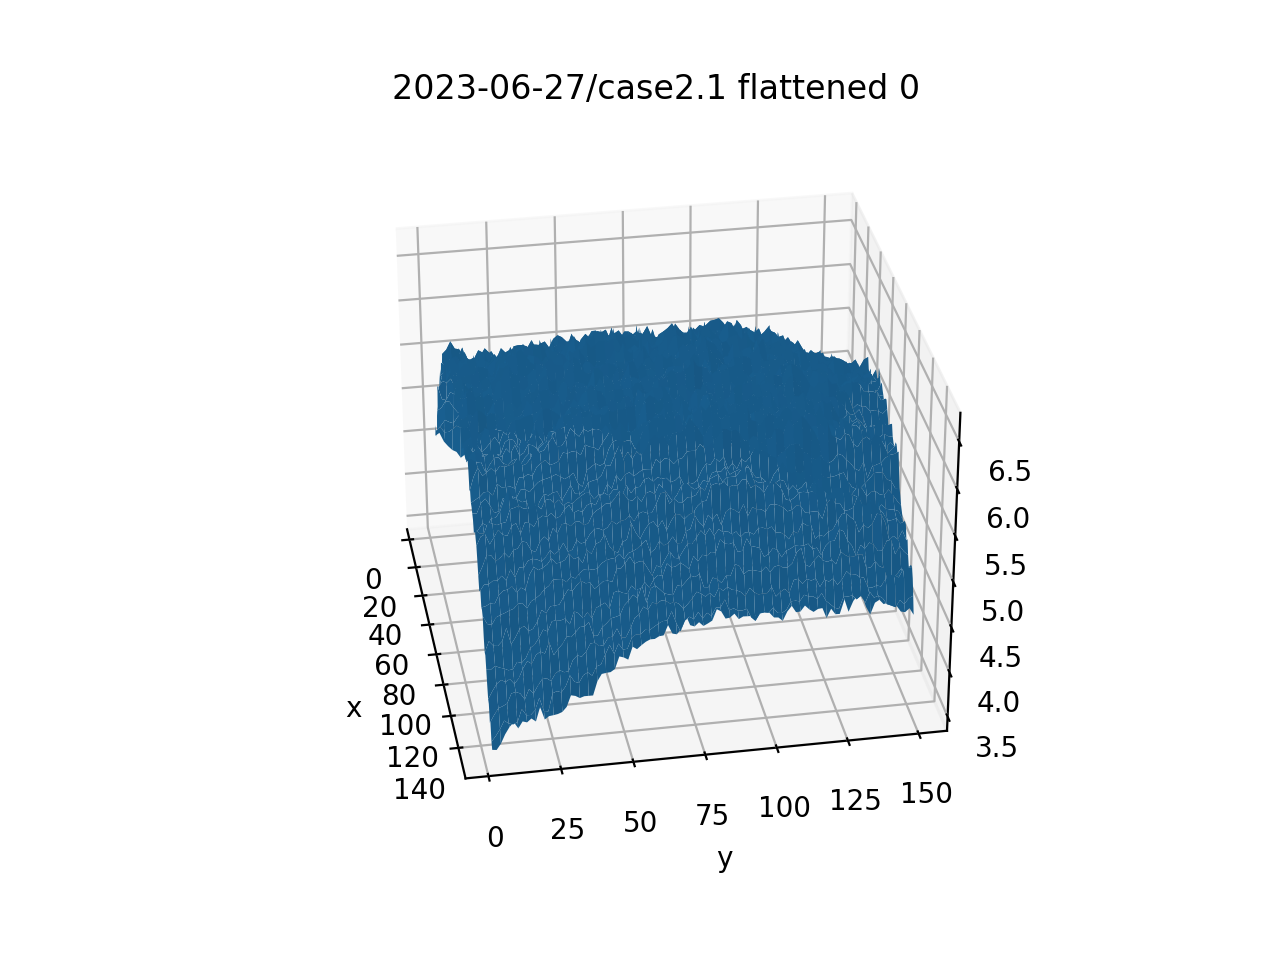

<IPython.core.display.Javascript object>


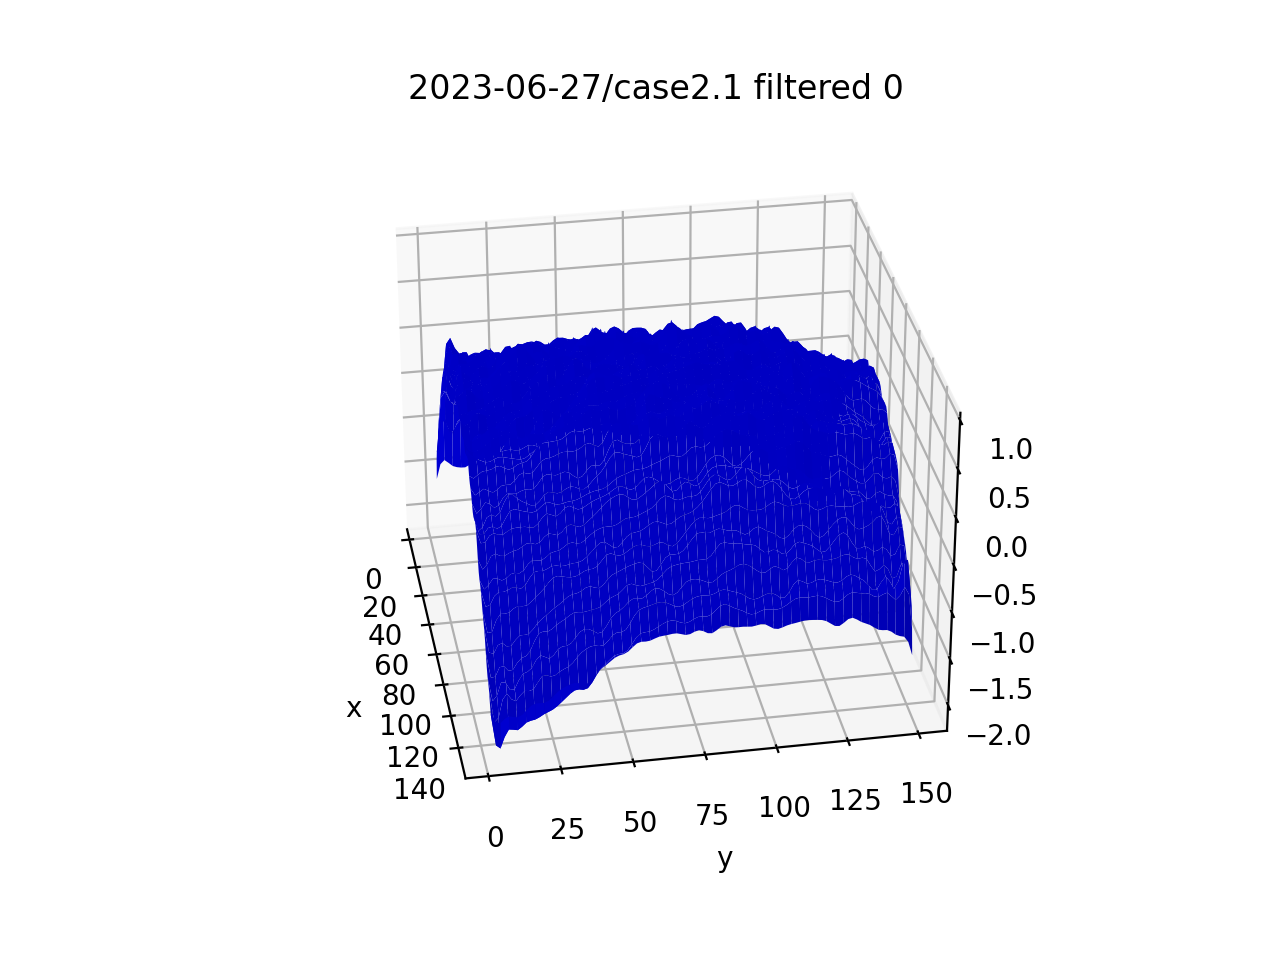

Segments_Pyramidal_compr_flat_filt_0_vx1.stl
Creating top mesh...
std dev of height (filtered) =  0.6265011940530988
std dev of height =  0.6672116380032703


<IPython.core.display.Javascript object>


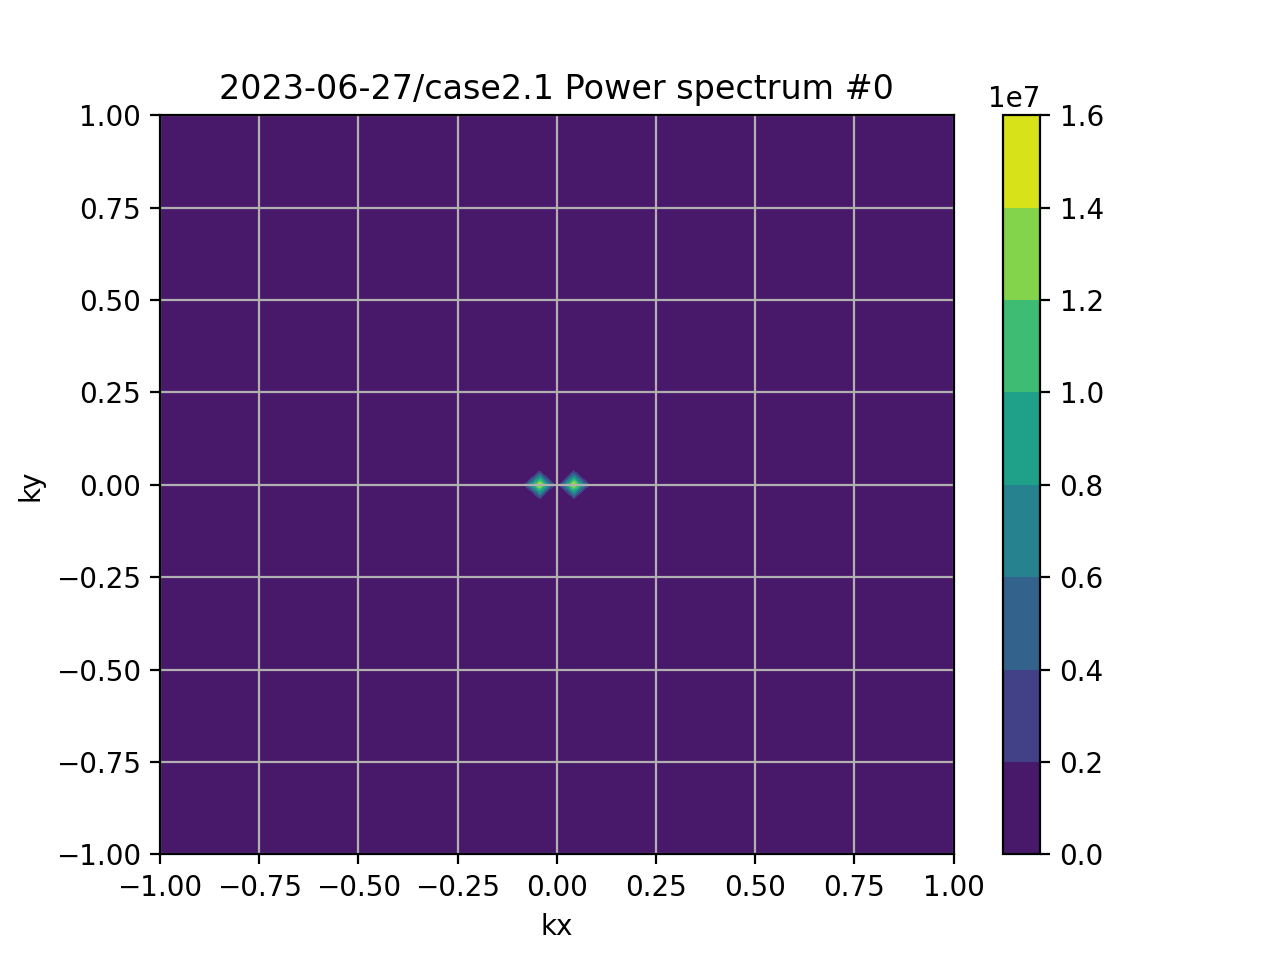

In [31]:
# Fourier transform, filter, and save them
plotthisone = [i for i in range(nsegments)]
vscale = 1
kmax = 1.
xseggrid_filtered = []
yseggrid_filtered = []
zseggrid_filtered = []

for i in range(nsegments):
    
    # Reporting
    print('Working on segment ', i)
    
    # Get the next flattened surface
    xgrid = xseggrid[i]
    ygrid = yseggrid[i]
    sollast = zseggrid[i]
    x = xgrid[0,:]; dx = x[1]-x[0]
    y = ygrid[:,0]
    Ny, Nx = np.shape(sollast)

    # Offset to zero
    sollast_offset = np.mean(sollast)
    sollast_atzero = sollast-sollast_offset
    
    # FFT
    solution_filtered = fs.filterseg(kmax,xgrid,ygrid,sollast_atzero)
    sollast_FT_filtered_IFT_real = solution_filtered[0]; print(np.shape(sollast_FT_filtered_IFT_real))
    kxshiftgrid = solution_filtered[1]
    kyshiftgrid = solution_filtered[2]
    sollast_FTshift_square = solution_filtered[3]
    
    # Plot one of them
    if i in plotthisone:
        
        # Graphing the flattened surface as a mesh
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(xseggrid[i], yseggrid[i], zseggrid[i])
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(case_and_folder + ' flattened '+str(i))
        ax.view_init(30, -10)
                
        # Save an stl file
        #stlfilename = Segmentroot+'_compr_flat'+'_'+str(i)+'_vx'+str(vscale)+'.stl'; print(stlfilename)
        #sls.numpy2stl(np.fliplr(zseggrid[i]), stlfilename, scale=vscale/dx, solid=False)

        # Graphing the filtered flattened surface as a mesh
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(xseggrid[i], yseggrid[i], sollast_FT_filtered_IFT_real,color='blue')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(case_and_folder + ' filtered '+str(i))
        ax.view_init(30, -10)
        
        # Save an stl file
        stlfilename = Segmentroot+'_compr_flat_filt'+'_'+str(i)+'_vx'+str(vscale)+'.stl'; print(stlfilename)
        sls.numpy2stl(np.fliplr(sollast_FT_filtered_IFT_real[1:-2,1:-2]), stlfilename, scale=vscale/dx, solid=False)
        
        # Report something about the heights
        print ('std dev of height (filtered) = ', np.std(sollast_FT_filtered_IFT_real[1:-2,1:-2]))
        print ('std dev of height = ', np.std(sollast))
        
        # FT plotting
        plt.figure()
        plt.contourf(kxshiftgrid, kyshiftgrid, sollast_FTshift_square)
        plt.colorbar()
        plt.xlim([-kmax,kmax])
        plt.ylim([-kmax,kmax])
        plt.xlabel('kx')
        plt.ylabel('ky')
        plt.title(case_and_folder + ' Power spectrum #'+str(i))
        plt.grid(True)
        
    # Pack the filtered segment into the big array (but getting rid of the edges)
    xseggrid_filtered.append(xgrid[1:-2,1:-2])
    yseggrid_filtered.append(ygrid[1:-2,1:-2])
    zseggrid_filtered.append(sollast_FT_filtered_IFT_real[1:-2,1:-2])

In [32]:
# Graphing the filtered flattened surface with plotly
print('plotting the last one')
fig = go.Figure(data=go.Surface(x=xseggrid[i],y=yseggrid[i],z=sollast_FT_filtered_IFT_real, colorscale="greys"))
fig.update_layout(scene = dict(
            xaxis_title='x',
            yaxis_title='y',
            zaxis_title='z'),
            title='test')

plotting the last one


In [33]:
# Do some uniforimization on the unfiltered array
nxmin,nymin = np.shape(xseggrid_filtered[0])
for i in range(len(xseggrid_filtered)):
    nx, ny = np.shape(xseggrid_filtered[i])
    if (nx<nxmin):
        nxmin = nx
    if (ny<nymin):
        nymin = ny
print('minima:', nxmin,nymin)
xseggrid_filtered_uni = []
yseggrid_filtered_uni = []
zseggrid_filtered_uni = []
for i in range(len(xseggrid_filtered)):
    xseggrid_filtered_uni.append(xseggrid_filtered[i][0:nxmin,0:nymin])
    yseggrid_filtered_uni.append(yseggrid_filtered[i][0:nxmin,0:nymin])
    zseggrid_filtered_uni.append(zseggrid_filtered[i][0:nxmin,0:nymin])

# Do some uniformization on the unfiltered array
nxmin,nymin = np.shape(xseggrid[0])
for i in range(len(xseggrid)):
    nx, ny = np.shape(xseggrid[i])
    if (nx<nxmin):
        nxmin = nx
    if (ny<nymin):
        nymin = ny
print('minima:', nxmin,nymin)
xseggrid_uni = []
yseggrid_uni = []
zseggrid_uni = []
for i in range(len(xseggrid_filtered)):
    xseggrid_uni.append(xseggrid[i][0:nxmin,0:nymin])
    yseggrid_uni.append(yseggrid[i][0:nxmin,0:nymin])
    zseggrid_uni.append(zseggrid[i][0:nxmin,0:nymin])

minima: 94 93
minima: 97 96


In [34]:
# Save the flattened segments
np.savez_compressed(Originalfilename, \
                    xgridtot=surf_xseggrid, \
                    ygridtot=surf_yseggrid, \
                    zgridtot=surf_zseggrid)

np.savez_compressed(Flattenedfilename, \
                    xgridtot=xseggrid_uni, \
                    ygridtot=yseggrid_uni, \
                    zgridtot=zseggrid_uni)

np.savez_compressed(Filteredfilename, \
                    xgridtot=xseggrid_filtered_uni, \
                    ygridtot=yseggrid_filtered_uni, \
                    zgridtot=zseggrid_filtered_uni)

In [35]:
# See if we can get some angles
ims.extractdots(npzfile,dx,dy)

In [36]:
# # This is just trying to understand how the FT works
# i = 0
# x = xseggrid[i][0,:]
# y = yseggrid[i][:,0]
# xgrid,ygrid = np.meshgrid(x,y)
# test = xseggrid[0]
# Ny, Nx = np.shape(test)

# # FT
# test_FTshift,kxshift,kyshift = fs.FT(test,x,y)
# kxshiftgrid,kyshiftgrid = np.meshgrid(kxshift,kyshift);
# test_FTshift_square = np.real(test_FTshift)**2 +  np.imag(test_FTshift)**2 
# plt.figure()
# plt.contour(kxshiftgrid, kyshiftgrid, test_FTshift_square)
# plt.xlabel('kx')
# plt.ylabel('ky')
# plt.title('Power spectrum')
# plt.grid(True)

# # Filter
# kmax = 2.6
# test_FTshift_filtered = test_FTshift*1
# for ix in range(Nx):
#     for iy in range(Ny):
#         ktest = np.sqrt(kxshiftgrid[iy,ix]**2+kyshiftgrid[iy,ix]**2)
#         if(ktest>kmax):
#             test_FTshift_filtered[iy,ix]=0

# # Inverse FT
# test_FT_filtered_IFT = fs.IFT(test_FTshift_filtered)
# print(np.shape(test_FT_filtered_IFT))
# print(np.shape(xgrid))

# # Plotting
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(xseggrid[i], yseggrid[i], test)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_title('original')
# ax.view_init(30, -10)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(xgrid, ygrid, np.real(test_FT_filtered_IFT),color='blue')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_title('smoothed')
# ax.view_init(30, -10)

# # fig = plt.figure()
# # ax = fig.add_subplot(111, projection='3d')
# # ax.plot_surface(xgrid, ygrid, np.real(test_FT_filtered_IFT-test),color='red')
# # ax.set_xlabel('x')
# # ax.set_ylabel('y')
# # ax.set_title('real difference')
# # ax.view_init(30, -10)

In [37]:
# # More attempts to understand how the FT works
# x = np.linspace(0,20,50)
# y = np.linspace(0,20,51)
# xgrid,ygrid = np.meshgrid(x,y)
# lambdax = 5; kx = np.pi*2/lambdax; print(kx)
# lambday = 2; ky = np.pi*2/lambday; print(ky)
# sollast = np.sin(kx*xgrid) + np.sin(ky*ygrid)
# Ny, Nx = np.shape(sollast)

# # FT
# sollast_FTshift,kxshift,kyshift = fs.FT(sollast,x,y)
# kxshiftgrid,kyshiftgrid = np.meshgrid(kxshift,kyshift);
# sollast_FTshift_square = np.real(sollast_FTshift)**2 +  np.imag(sollast_FTshift)**2 


# # Plotting
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(xgrid, ygrid, sollast)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_title('original')

# plt.figure()
# plt.contour(kxshiftgrid, kyshiftgrid, sollast_FTshift_square)
# plt.xlabel('kx')
# plt.ylabel('ky')
# plt.title('Power spectrum')
# plt.grid(True)
